In [3]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Random d-Dimensional embeddings generation

In [4]:
# defining the minimum no of vectors allowed in a node
min_subset_size=5

In [5]:
# defining the number of random embeddings (let us consider 1000 random embeddings)
n_vectors = 100
d = 10

# initializing an empty list to store the embeddings
vectors = []

# generating 1000  random embeddings
for i in range(n_vectors):
    # generate a random d-dim embeddings
    random_vector = [round(100 * random.random(), 2) for _ in range(d)]
    vectors.append(np.array(random_vector))

### Implementing the ANNOY Tree

In [6]:
class Node:
    def __init__(self,hyperplane=None,constant=None,values=None):
        """
        hyperplane : the equation of the hyperplane equidistant from the two points
        constant   : the constant term in the hyperplane equation
        values     : the vectors to separate based on the hyperplane
        """
        self.hyperplane=hyperplane
        self.constant = constant
        self.values=values
        # vectors  that lie to the left hand side of the hyperplane
        self.left=None
        # vectors that lie to the right hand side of the hyperplane
        self.right=None

In [7]:
# find the equidistant point from the two given vectors
def hyperplane_equation(v1:np.ndarray,v2:np.ndarray):
    """
    returns the equation of the hyperplane equidistant from v1 and v2 
    v1 : vector1
    v2 : vector2
    """
    # finding the normal vector
    normal_vector = v2-v1
    # finding the midpoint
    midpoint = (v1+v2)/2
    # finding the const term
    const_term = np.dot(normal_vector,midpoint)
    return normal_vector,const_term

# checking which side of the hyperplane does the vector lies
def check_vector_side(normal_vector,constant,vector):
    """
    returns which side to the hyperplane does the vector lies
    normal_vector   : the vector normal to the hyperplane
    constant        : constant term in the hyperplane
    vector          : the vector whose side we want to find
    """
    # performing the dot product between the normal vector and vector
    result = np.dot(normal_vector,vector)
    if result<constant:
        side="right"
    else:
        side="left"
    return side

In [8]:
# testing the function
hyperplane_equation(vectors[0],vectors[1])

(array([-12.49,  56.11, -13.04,  17.15,   8.41, -24.88,  44.46,   8.1 ,
         44.85,   1.4 ]),
 5814.539049999999)

### Building the ANNOY Tree
Till both randomly selected vectors are same
1. Find random 2 vectors from the all given vectors in the set
2. Find a equidistant hyperplane between these two vectors
3. Put all the vectors that are right side to the hyperplane to a set called A
4. Put all the vectors that are left side to the hyperplane to a set called B
5. Repeat all previous steps in both set A and B recursively

In [9]:
# building the tree
def build_tree(vectors):
    """
    builds the tree using the given vectors to find approximate nearest neighbors and returns the root node of the Tree
    vectors: list of all vectors
    """
    idx1 = 0
    idx2 = 0
    while idx1==idx2:
        # pick any two random numbers withing the number of vectors range 
        idx1 = random.randint(0,len(vectors)-1)
        idx2 = random.randint(0,len(vectors)-1)
     # pick any two random vectors from the list of vectors 
    first_vector = vectors[idx1]
    second_vector = vectors[idx2]
    # find the equidistant hyperplane between first vector and second vector
    hyperplane,constant = hyperplane_equation(first_vector,second_vector)
    # classfiy all vectors in the vectors list are on left or right with respect to hyperplane
    left_nodes=[]
    right_nodes=[]
    for vector in vectors:
        side = check_vector_side(hyperplane,constant,vector)
        # appending the vectors that lie to the right side of the hyperplane in right nodes
        if side=="right":
            right_nodes.append(vector)
        elif side=="left":
            left_nodes.append(vector)
    # building the current tree node
    current_node = Node(hyperplane=hyperplane,constant=constant,values=vectors)
    
    # if the size of left node is greater than the min_subset_size (if so we need to split it further)
    if len(left_nodes)>min_subset_size:
        current_node.left = build_tree(left_nodes)
    else:
        current_node.left = Node(values=left_nodes)

    # if the size of left node is greater than the min_subset_size (if so we need to split it further)
    if len(right_nodes)>min_subset_size:
        current_node.right = build_tree(right_nodes)
    else:
        current_node.right = Node(values=right_nodes)

    return current_node

In [10]:
# testing the build tree function
test_tree = build_tree(vectors)

### Traversing throught the tree to find the nearest neighbors

In [11]:
# searching for the nearest neighbors through tree
def search(tree,query_vector):
    """
    returns the list of nearest neighbors of the query vector by traversing through the ANNOY tree
    tree         : ANNOY tree built using build_tree function
    query_vector : vector whose nearest neighbors we want to find
    

    leaf node has three condition 
    1. the size of values attribute of the leaf node is less than the min_subset_size 
    2. the hyperplane attribute of the leaf node is None (as there is no hyperplane needed to split the node further if the first conditon is satisfied )
    3. the constant attribute of the leaf node is None  (as there is no hyperplane needed to split the node further if the first conditon is satisfied )
    """
    # traversing till we reach leaves
    while len(tree.values)>min_subset_size and tree.hyperplane is not None and tree.constant is not None:
        # checking the side of the vector sample
        side = check_vector_side(tree.hyperplane,tree.constant,query_vector)
        if side=="left":  
            print(f"go to left {len(tree.values)}")
            tree = tree.left
        elif side=="right":
            print(f"go to right {len(tree.values)}")
            tree = tree.right
    print("The Neightbors are\n",tree.values)
    return tree.values

In [15]:
# testing the search function
sample = [50 for _ in range(10)]
nearest_neighbors = search(test_tree,sample)

go to left 100
go to right 57
go to right 30
go to right 20
go to left 17
go to left 12
go to right 6
The Neightbors are
 [array([14.87, 66.64, 44.88,  2.88, 74.05, 67.13, 59.57, 64.45, 77.18,
       48.53]), array([89.21, 72.25, 83.07, 36.83, 52.68, 32.15, 11.93, 40.18, 82.17,
       97.24]), array([85.03, 92.69, 59.92, 25.93,  8.8 , 56.88, 73.01, 70.34, 44.28,
       98.07]), array([11.23, 56.71, 37.27, 22.38, 84.26, 39.9 , 42.25, 93.98, 83.26,
       60.5 ])]


### Visualizing 

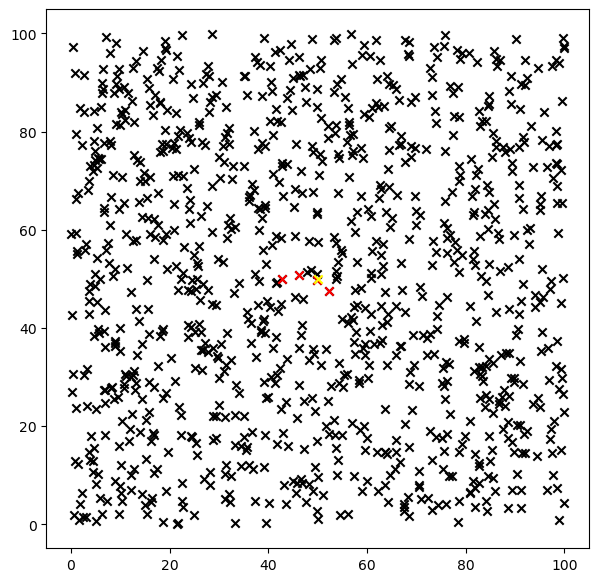

In [56]:
# visualizing the embeddings
fig = plt.figure(figsize=(7,7))
for i in range(n_vectors):
    plt.scatter(vectors[i][0],vectors[i][1],c="black",marker="x")
for j in nearest_neighbors:
    plt.scatter(j[0],j[1],c="red",marker="x")
plt.scatter(sample[0],sample[1],c="yellow",marker="x")
plt.show()